In [30]:
import matplotlib.pylab as plt 

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy
import math
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np



# Part 1: TF Hub

## Load Classifier

In [3]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


## Load image from the internet

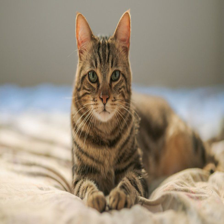

In [5]:
import numpy as np
import PIL.Image as Image

img = tf.keras.utils.get_file('cat.jpg','https://ichef.bbci.co.uk/news/976/cpsprodpb/12A9B/production/_111434467_gettyimages-1143489763.jpg')
img = Image.open(img).resize((IMAGE_RES, IMAGE_RES))
img 

In [6]:
img = np.array(img)/255.0
img= img[:,:,:3]
img.shape

(224, 224, 3)

## Predict image class

In [7]:
result = model.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
print (img.shape)
print (img[np.newaxis, ...].shape)
print (np.array([img]).shape)

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

283

## Get classes names and assign predicted class

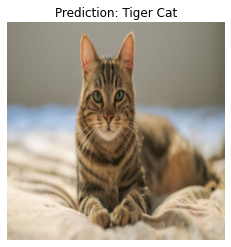

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: TF Hub for Cats VS Dogs

## Load data

In [11]:
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [12]:
num_examples

3670

In [13]:
num_classes

5

In [14]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (333, 500, 3)
Image 2 shape: (212, 320, 3)
Image 3 shape: (240, 320, 3)


In [15]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [16]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['jellyfish', 'daisy', 'wig', 'bee', 'fly', 'daisy', 'daisy', 'bee',
       'vase', 'pot', 'picket fence', 'shower curtain', 'daisy',
       'bicycle-built-for-two', 'packet', 'sulphur-crested cockatoo',
       'daisy', 'handkerchief', 'cardoon', 'daisy', 'microwave', 'daisy',
       'bell pepper', 'daisy', 'daisy', 'daisy', 'harvestman', 'perfume',
       'daisy', 'soccer ball', 'strawberry', 'sea urchin'], dtype='<U30')

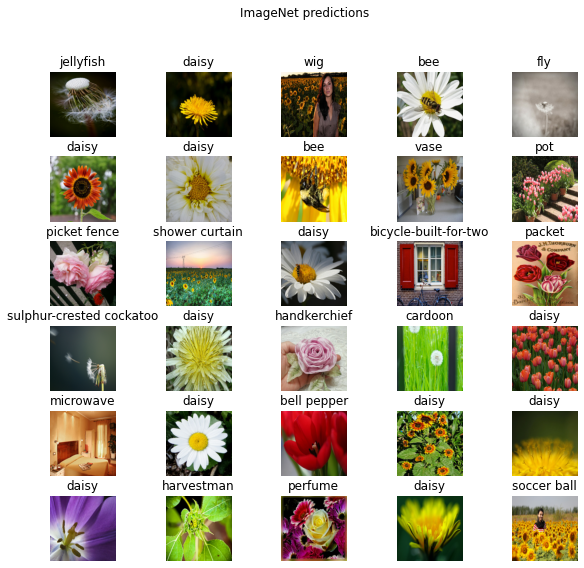

In [17]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Get the model

In [18]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [19]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [20]:
feature_extractor.trainable = False

In [21]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 2
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2
81/81 [==============================] - 77s 915ms/step - loss: 0.3248 - accuracy: 0.8940 - val_loss: 0.3273 - val_accuracy: 0.8901
Epoch 2/2
81/81 [==============================] - 74s 910ms/step - loss: 0.2412 - accuracy: 0.9278 - val_loss: 0.3072 - val_accuracy: 0.8919


## Visualize training history

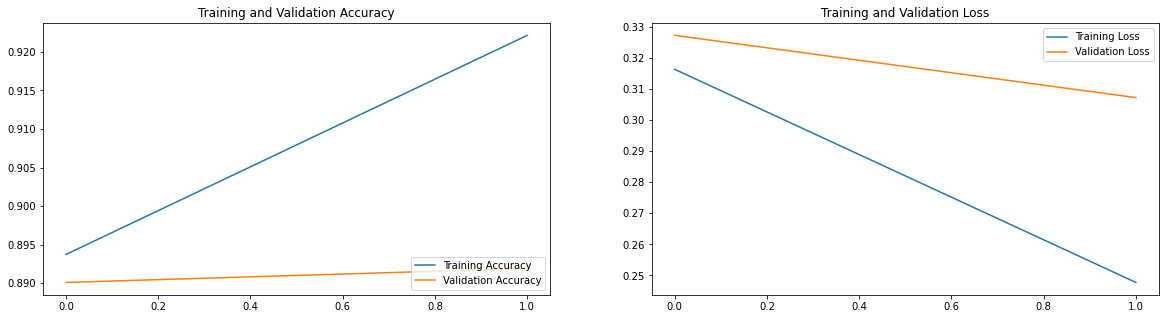

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [26]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dandelion', 'dandelion', 'sunflowers', 'daisy', 'dandelion',
       'sunflowers', 'daisy', 'dandelion', 'sunflowers', 'tulips',
       'roses', 'sunflowers', 'daisy', 'roses', 'roses', 'dandelion',
       'dandelion', 'roses', 'dandelion', 'tulips', 'roses', 'daisy',
       'tulips', 'sunflowers', 'dandelion', 'daisy', 'sunflowers',
       'roses', 'dandelion', 'sunflowers', 'tulips', 'dandelion'],
      dtype='<U10')

In [27]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 3 1 0 3 1 3 3 2 4 3 1 2 2 0 0 4 0 2 4 1 2 3 0 2 3 4 0 3 2 0]
Predicted labels:  [0 0 3 1 0 3 1 0 3 2 4 3 1 4 4 0 0 4 0 2 4 1 2 3 0 1 3 4 0 3 2 0]


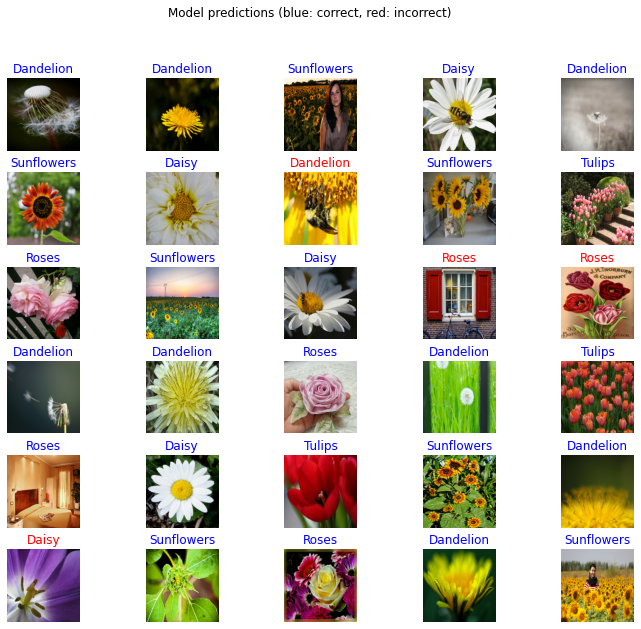

In [28]:
plt.figure(figsize=(12,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [31]:
y_pred = model.predict(train_batches)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in train_batches], axis=0)

cm=confusion_matrix(predicted_categories, true_categories)

In [32]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [33]:
cm_plot_labels = ['no_side_effects','had_side_effects']   

Confusion matrix, without normalization
[[159 102 147 121 109]
 [112  79  87  96  76]
 [121  87 123  78  92]
 [121  84  80 110  97]
 [126  93  94  91  84]]


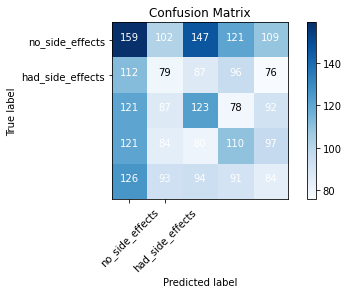

In [34]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')